
# Utilities

In [33]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [34]:
import os
os.chdir('/content/drive/My Drive/BT5450/Project')

!pwd

/content/drive/My Drive/BT5450/Project


In [69]:
import numpy as np
import pandas as pd
from math import ceil

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

random_seed = 123
from IPython.display import display
%matplotlib inline

In [92]:
style_df = lambda df:df.head(50).style.set_table_styles(
[{'selector': 'th',
  'props': [('background', '#FFFEE3'), 
            ('color', 'black'),
            ('font-family', 'verdana')]},
 
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},

 {'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#ADD8E6')]}, 
 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 
 {'selector': 'tr:hover',
  'props': [('background-color', '#FFFEE3')]}
]
)

In [36]:
#Custom function imports.
from customPreprocess import preprocess
from plotUtils import plt_target, plt_residuals

**A function that helps with fitting the model as well as hypertuning the parameters**

In [89]:
def fit_models(models,
               X_train,
               y_train,
               X,
               y,
               n_jobs=-1,
               verbose=2,
               random_seed=123,
               save_plots =False):
    '''
    A method that fits models on the dataset and does
    hyperparmater tuning.
    '''
    #A variable to store the best model and corresponding results.
    result_dict = {}

    #Iterating through all the models.
    for model_name, config in models.items():

        print('---' * 25)
        print('---' * 25)
        print(f'[INFO] Model being fitted: {model_name}')

        #Finding the optimal model parameters using gridsearch.
        gs = GridSearchCV(estimator=config['estimator'],
                          param_grid=config['params'],
                          n_jobs=n_jobs,
                          scoring='r2',
                          cv=3,
                          refit=True,
                          verbose=verbose)

        #Fitting the optimal model.
        gs.fit(X_train, y_train)
        
        '''Printing the results of GridSearch'''
        print(f'--' * 25)
        print(f'[INFO] {model_name} gridsearch results on training dataset...')

        means = gs.cv_results_['mean_test_score']
        stds = gs.cv_results_['std_test_score']

        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            print(f'[INFO] R2 score: {mean} (+/- {std}) for {params}')
        print('--'*25)
        print(f'[INFO] {model_name} best score: {gs.best_score_}')
        print(f'[INFO] {model_name} best parameters: {gs.best_params_}')

        print(f'---' * 25)
        '''Evaluating the best estimator performance on the whole dataset'''

        print(f'---' * 25)
        print(
            f'[INFO] {model_name} model validation on the entire dataset results...'
        )

        estimator = gs.best_estimator_

        shuffle = KFold(n_splits=5, shuffle=True, random_state=random_seed)

        cv_scores = cross_val_score(estimator=estimator,
                                    X=X,
                                    y=y.ravel(),
                                    cv=shuffle,
                                    scoring='r2',
                                    n_jobs=n_jobs)

        r2 = cv_scores.mean()
        print(f'[INFO] Mean R2-score on the entire dataset: {r2}')

        y_pred = cross_val_predict(estimator, X, y, cv=shuffle)
        MSE = mean_squared_error(y, y_pred)

        print(f'[INFO] Plotting...')

        #Plots.
        fig1 = plt_target(y, y_pred, r2, MSE, model_name)
        fig2 = plt_residuals(y, y_pred, model_name, figsize=(18, 6))

        if save_plots:
            fig1.savefig(f'./plots/{model_name}_actual_vs_predicted.png')
            fig2.savefig(f'./plots/{model_name}_residuals.png')
            

        #Feature importance plot.
        try:
            print(f'[INFO] Visualizing the feature significane')
            feat_imp = pd.Series(
                estimator.named_steps['model'].feature_importances_,
                index=X_train.columns).sort_values(ascending=False)
            
            fig = plt.figure(figsize=(12,8))
            
            bar_plot = sns.barplot(x=feat_imp.index, y=feat_imp, color='darkcyan')
            plt.xticks(rotation=90)
            
            plt.suptitle(f'{model_name} Feature significane', fontsize=20)
            plt.show()
            if save_plots:
                plt.savefig(f'./plots/{model_name}_feature_significance.png')
            
        except:
            print(
                f'[INFO] The model does not have feature significane attribute'
            )

        result_dict[model_name] = {
            'estimator': estimator,
            'Predictions': y_pred
        }

    return result_dict

# Hyperparamter Tuning 

Here, we fit classic machine learning regression models on the processed dataset.

The different models fitted here are,

* Linear regression with out regularization
* Linear regression with lasso (L1) regularization
* Linear regressioin with ridge (L2) regularization
* Decision trees
* Random forest regressor
* XGBoost regressor

Here we have fine tuned the various hyperparameters (5-fold cross-validation) associated with the regression models as well. 


## Loading the data with no applied insights

In [77]:
dataframe = pd.read_csv(r'./Data/Train/traffic.csv', sep=';')

In [79]:
X,y = preprocess(r'./Data/Train/traffic.csv', apply_log=False)

In [82]:
#Splitting into train and test.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=dataframe['Hour (Coded)'])

print(f'[INFO] Training dataset size: {X_train.shape[0]} samples.')
print(f'[INFO] Test dataset size: {X_test.shape[0]} samples.')

[INFO] Training dataset size: 108 samples.
[INFO] Test dataset size: 27 samples.


In [42]:
#Numeric features.
num_features = X.select_dtypes(include=['int64']).columns

In [43]:
#Scaling the numeric features.
T = [('num', StandardScaler(), num_features)]
col_transform = ColumnTransformer(transformers=T, remainder='passthrough')

## Linear Regression Models

In [44]:
#Linear regression.
pipe_lr = Pipeline([('scaling', col_transform),
                    ('model', LinearRegression())])

#Lasso regression.
pipe_lasso = Pipeline([('scaling', col_transform),
                    ('model', Lasso(max_iter=10000))])

#Ridge regression.
pipe_ridge = Pipeline([('scaling', col_transform),
                    ('model', Ridge())])

In [ ]:
models = {
    'Linear Regression': {
        'estimator': pipe_lr,
        'params': {}
    },
    'Lasso Regression': {
        'estimator': pipe_lasso,
        'params': {
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 3, 6, 10, 100, 1000]
        }
    },
    'Ridge Regression': {
        'estimator': pipe_ridge,
        'params': {
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 3, 6, 10, 100, 1000]
        }
    }
}

---------------------------------------------------------------------------
---------------------------------------------------------------------------
[INFO] Model being fitted: Linear Regression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
--------------------------------------------------
[INFO] Linear Regression gridsearch results on training dataset...
[INFO] R2 score: 0.5519568844004815 (+/- 0.11792017779819636) for {}
--------------------------------------------------
[INFO] Linear Regression best score: 0.5519568844004815
[INFO] Linear Regression best parameters: {}
---------------------------------------------------------------------------
---------------------------------------------------------------------------
[INFO] Linear Regression model validation on the entire dataset results...
[INFO] Mean R2-score on the entire dataset: 0.6417668071043886
[INFO] Plotting...


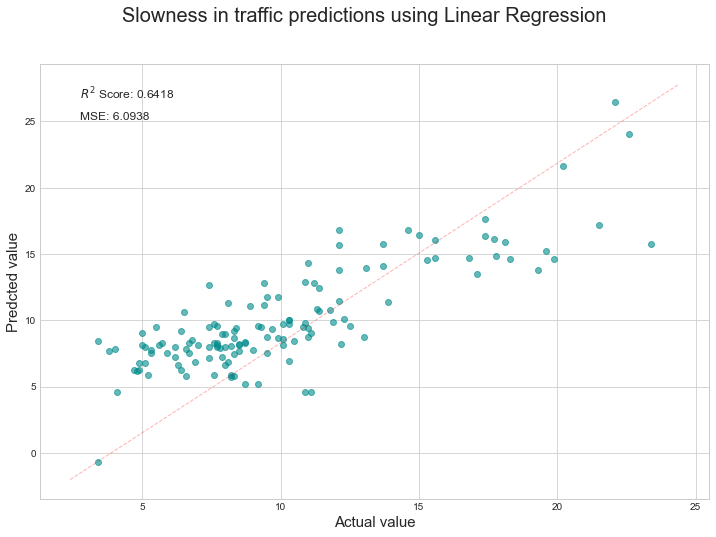

[INFO] Visualizing the feature significane
[INFO] The model does not have feature significane attribute
---------------------------------------------------------------------------
---------------------------------------------------------------------------
[INFO] Model being fitted: Lasso Regression
Fitting 3 folds for each of 10 candidates, totalling 30 fits
--------------------------------------------------
[INFO] Lasso Regression gridsearch results on training dataset...
[INFO] R2 score: 0.5521427740576509 (+/- 0.11778242323513045) for {'model__alpha': 0.0001}
[INFO] R2 score: 0.5538176182378028 (+/- 0.1165552829109456) for {'model__alpha': 0.001}
[INFO] R2 score: 0.5691680066523042 (+/- 0.10481539750297299) for {'model__alpha': 0.01}
[INFO] R2 score: 0.6061298375470342 (+/- 0.05658157380302223) for {'model__alpha': 0.1}
[INFO] R2 score: 0.1292345433284947 (+/- 0.14313023178359022) for {'model__alpha': 1.0}
[INFO] R2 score: -0.15624341958124144 (+/- 0.09968004554988256) for {'model__

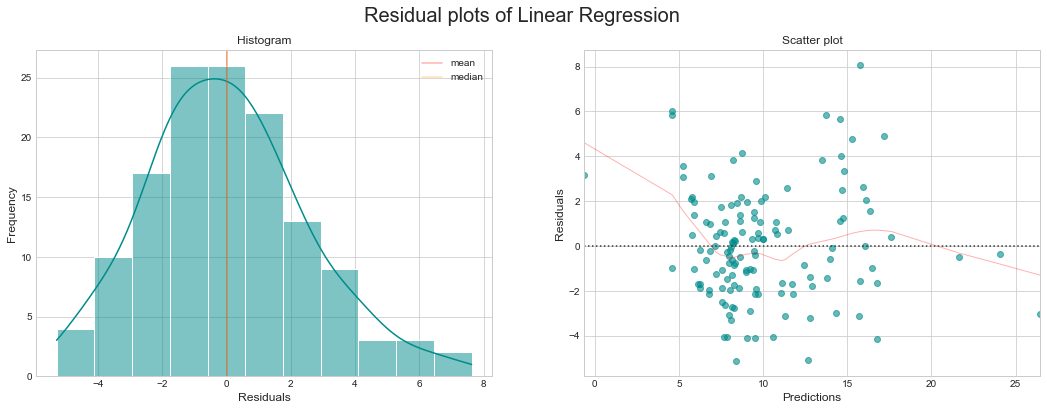

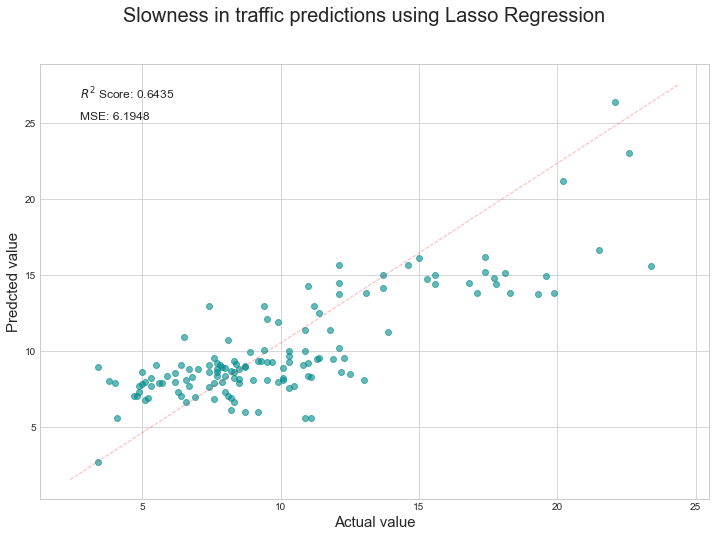

[INFO] Visualizing the feature significane
[INFO] The model does not have feature significane attribute
---------------------------------------------------------------------------
---------------------------------------------------------------------------
[INFO] Model being fitted: Ridge Regression
Fitting 3 folds for each of 10 candidates, totalling 30 fits
--------------------------------------------------
[INFO] Ridge Regression gridsearch results on training dataset...
[INFO] R2 score: 0.5519572749314093 (+/- 0.11792134576590106) for {'model__alpha': 0.0001}
[INFO] R2 score: 0.5519607857425531 (+/- 0.11793185564540809) for {'model__alpha': 0.001}
[INFO] R2 score: 0.5519955019770523 (+/- 0.11803677364217671) for {'model__alpha': 0.01}
[INFO] R2 score: 0.5523043370439367 (+/- 0.11906822046790565) for {'model__alpha': 0.1}
[INFO] R2 score: 0.5522842174527632 (+/- 0.12790080518831637) for {'model__alpha': 1.0}
[INFO] R2 score: 0.5409460322025913 (+/- 0.1414398234595884) for {'model__al

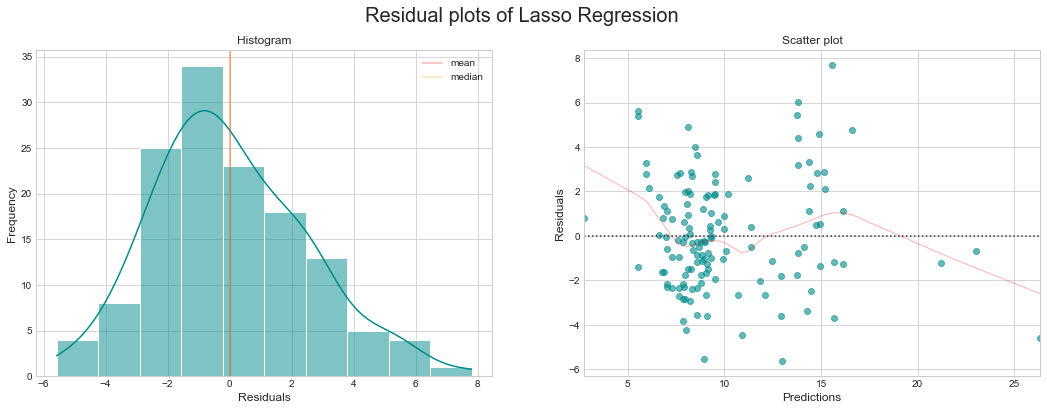

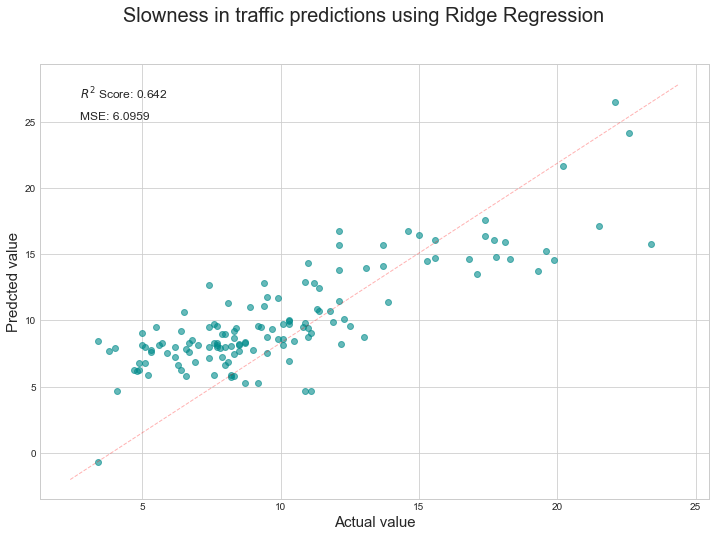

[INFO] Visualizing the feature significane
[INFO] The model does not have feature significane attribute


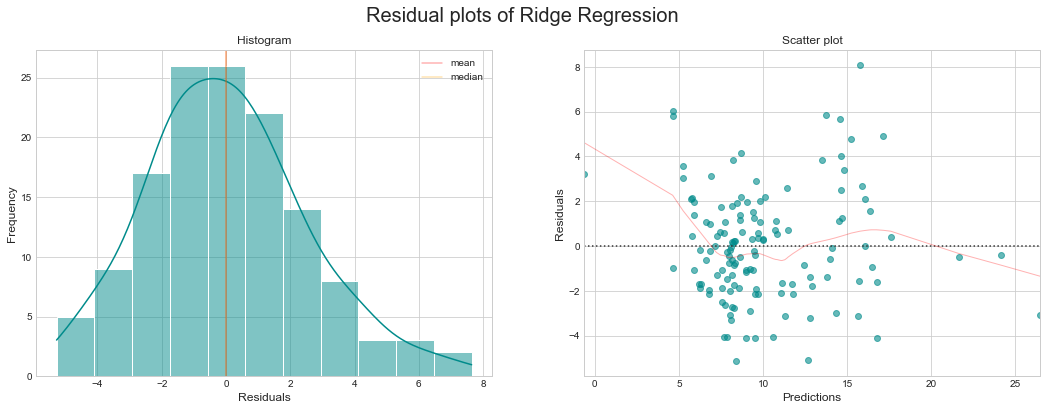

In [ ]:
lr_results = fit_models(models,X_train, y_train, X, y)

## Trees

In [45]:
#Decision tree.
pipe_tree = Pipeline([('scaling', col_transform),
                    ('model', DecisionTreeRegressor(random_state=random_seed))])

#Randomforest.
pipe_forest = Pipeline([('scaling', col_transform),
                    ('model', RandomForestRegressor(random_state=random_seed))])



In [ ]:
models = {
    'Decision Tree': {
        'estimator': pipe_tree,
        'params': {
            'model__max_depth': [2, 3, 5, 10, 20],
            'model__min_samples_leaf': [5]
        }
    },
    'Random Forest': {
        'estimator': pipe_forest,
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [5, 50, 100]
        }
    }
}

---------------------------------------------------------------------------
---------------------------------------------------------------------------
[INFO] Model being fitted: Decision Tree
Fitting 3 folds for each of 5 candidates, totalling 15 fits
--------------------------------------------------
[INFO] Decision Tree gridsearch results on training dataset...
[INFO] R2 score: 0.5510759151571613 (+/- 0.14515673757104466) for {'model__max_depth': 2, 'model__min_samples_leaf': 5}
[INFO] R2 score: 0.5806165984556187 (+/- 0.15917592060363542) for {'model__max_depth': 3, 'model__min_samples_leaf': 5}
[INFO] R2 score: 0.5948973110846335 (+/- 0.15458059831587925) for {'model__max_depth': 5, 'model__min_samples_leaf': 5}
[INFO] R2 score: 0.6130603111776972 (+/- 0.17162458108107698) for {'model__max_depth': 10, 'model__min_samples_leaf': 5}
[INFO] R2 score: 0.6130603111776972 (+/- 0.17162458108107698) for {'model__max_depth': 20, 'model__min_samples_leaf': 5}
-------------------------------

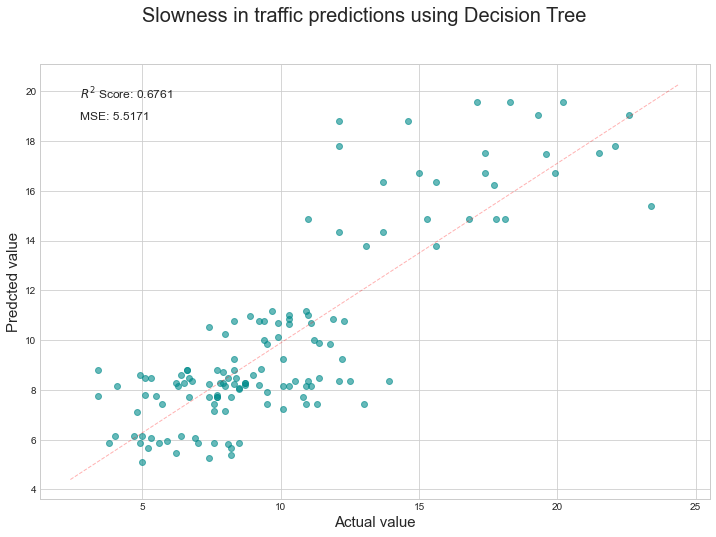

[INFO] Visualizing the feature significane


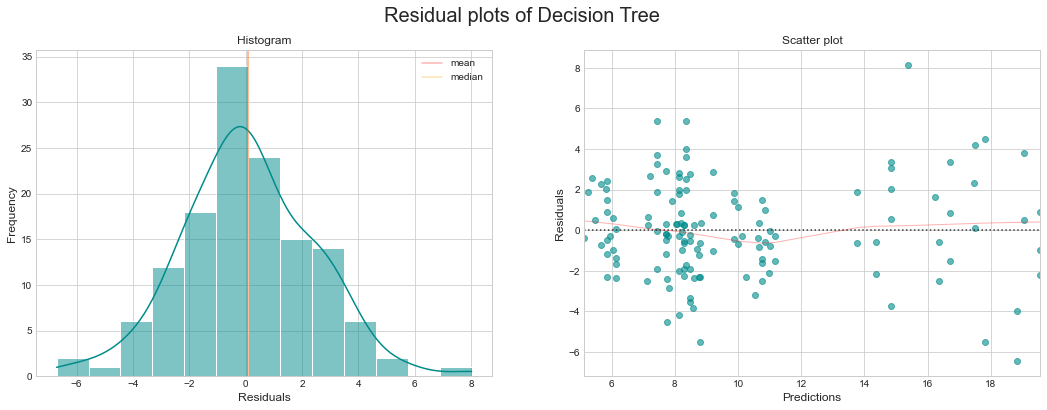

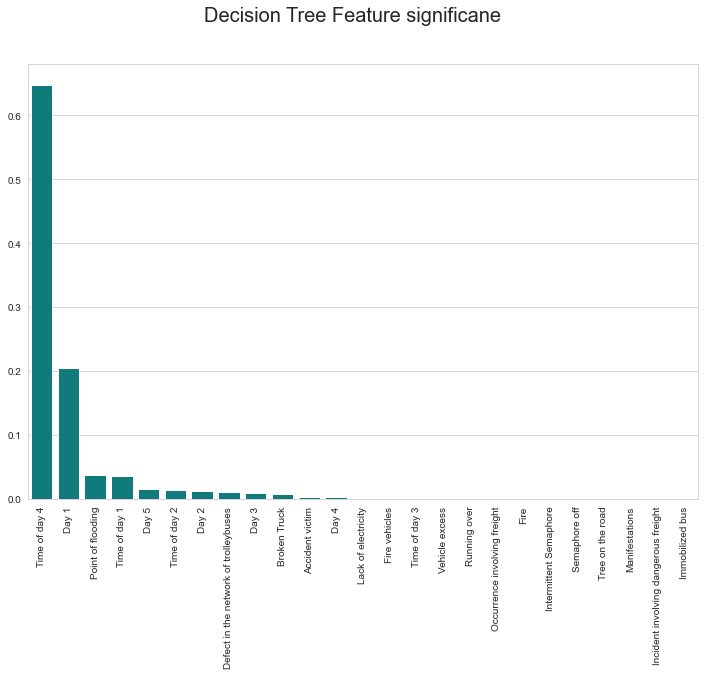

---------------------------------------------------------------------------
---------------------------------------------------------------------------
[INFO] Model being fitted: Random Forest
Fitting 3 folds for each of 6 candidates, totalling 18 fits
--------------------------------------------------
[INFO] Random Forest gridsearch results on training dataset...
[INFO] R2 score: 0.7058266080345116 (+/- 0.0258971944387631) for {'model__max_depth': 5, 'model__n_estimators': 50}
[INFO] R2 score: 0.7098510956001033 (+/- 0.02972447589075586) for {'model__max_depth': 5, 'model__n_estimators': 100}
[INFO] R2 score: 0.7098205508251653 (+/- 0.03275432184391838) for {'model__max_depth': 50, 'model__n_estimators': 50}
[INFO] R2 score: 0.7101371922409999 (+/- 0.03147514229092137) for {'model__max_depth': 50, 'model__n_estimators': 100}
[INFO] R2 score: 0.7098205508251653 (+/- 0.03275432184391838) for {'model__max_depth': 100, 'model__n_estimators': 50}
[INFO] R2 score: 0.7101371922409999 (+/- 0.

<Figure size 432x288 with 0 Axes>

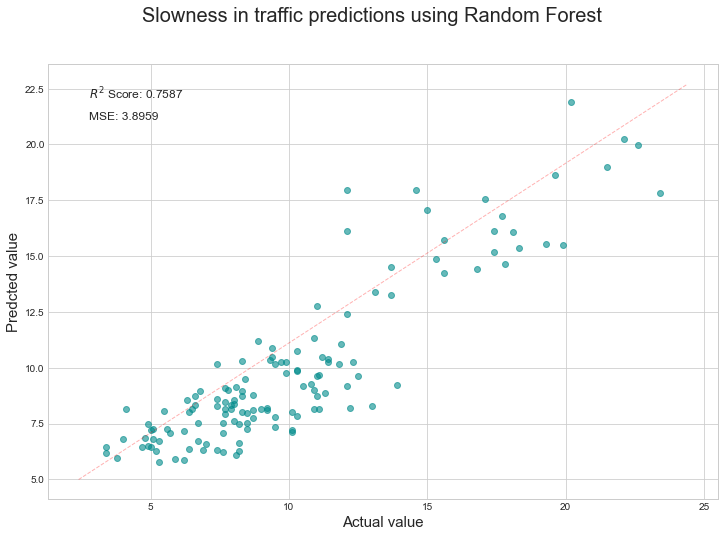

[INFO] Visualizing the feature significane


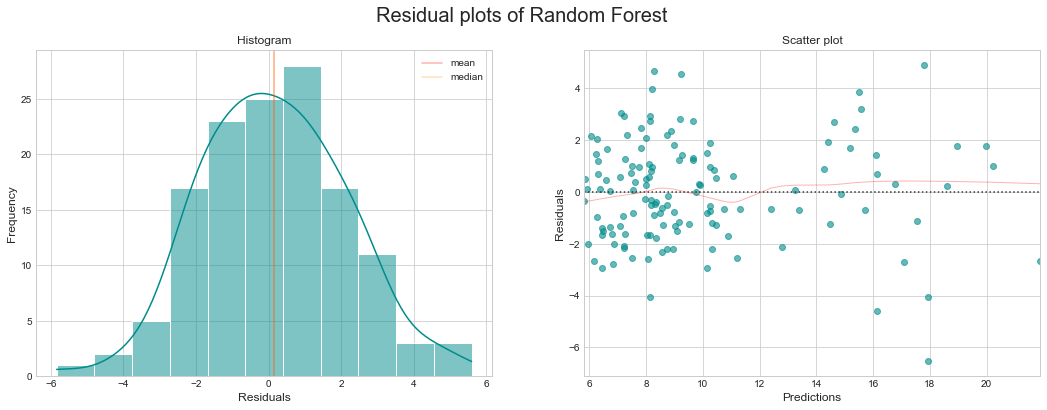

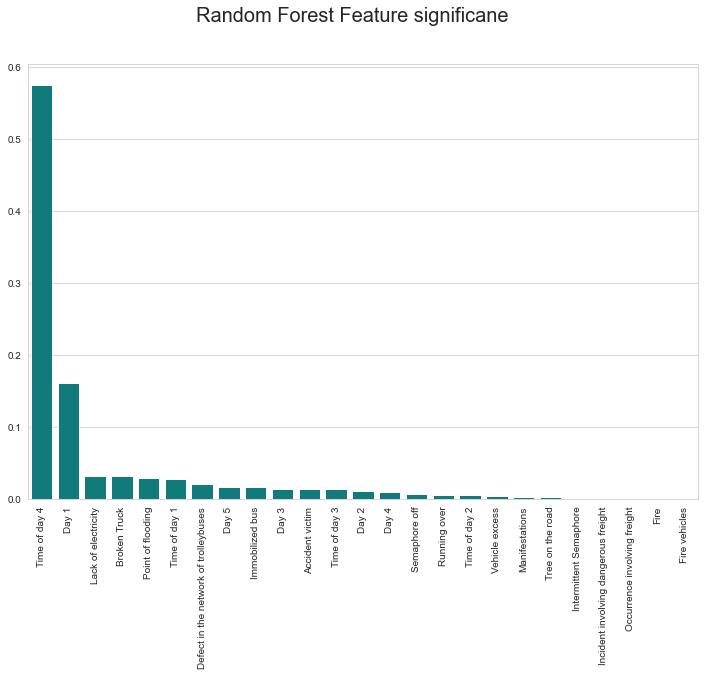

<Figure size 432x288 with 0 Axes>

In [ ]:
tree_results = fit_models(models,X_train, y_train, X, y)

## XGBRegressor

In [46]:
pipe_xgb  = Pipeline([('model', XGBRegressor(random_state=random_seed, tree_method = 'gpu_hist'))])


In [ ]:
model = {
    'XGBoost Regression': {
        'estimator': pipe_xgb,
        'params': {
            'model__max_depth': [3, 6, 10],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__n_estimators': [100, 500, 1000],
            'model__colsample_bytree':[0.3, 0.7]
        }
    }
}

---------------------------------------------------------------------------
---------------------------------------------------------------------------
[INFO] Model being fitted: XGBoost Regression
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[05:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
[INFO] XGBoost Regression gridsearch results on training dataset...
[INFO] R2 score: -0.3736067199705662 (+/- 0.30418502175105677) for {'model__colsample_bytree': 0.3, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
[INFO] R2 score: 0.6514089029182388 (+/- 0.012025040063168783) for {'model__colsample_bytree': 0.3, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500}
[INFO] R2 score: 0.6934401593151397 (+/- 0.015987683497330662) for {'model__colsample_bytree': 0.3, 'model__learning_rate': 0.01, 'm

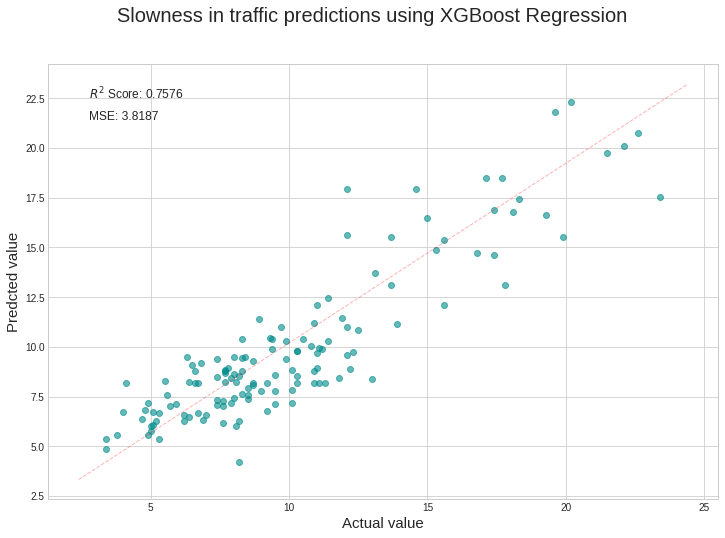

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[INFO] Visualizing the feature significane


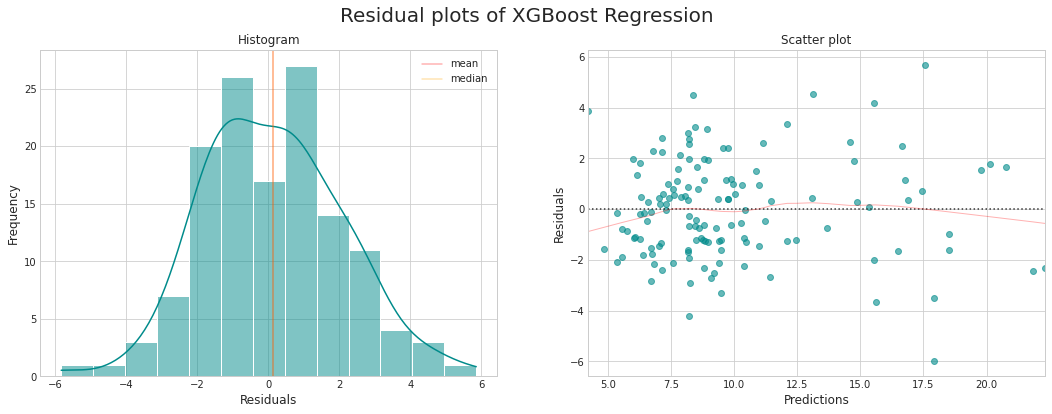

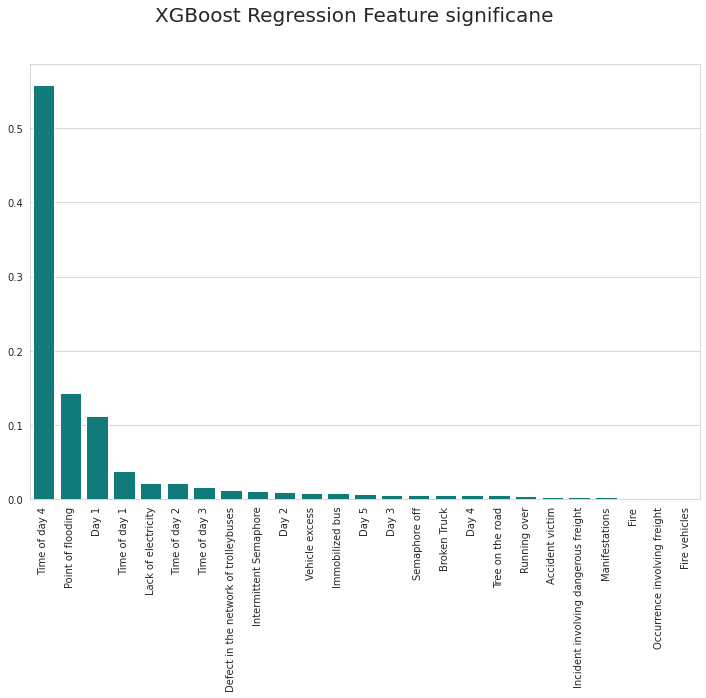

<Figure size 432x288 with 0 Axes>

In [ ]:
res = fit_models(model,X_train, y_train, X, y)

# Making Predictions

Here we will use the fine tuned hyperparameters baseed models from the previous section to make predictions on the test dataset.

The fine tuned parameters for various models are,

| Model | Hyperparameters | Validation R2 score | MSE |
|---|---|---|---|
| Linear Regression | None                                              | 0.6418 | 6.0938 |
| Lasso             | alpha: 0.1                                        | 0.6435 | 6.1948 |
| Ridge             | alpha: 0.1                                        | 0.6420 | 6.0959 |      
| Decision tree     |  max_depth: 10, min_samples_leaf': 5              | 0.6760 | 5.5171 |
| Random Forest     |  max_depth: 50, n_estimators': 100                | 0.7586 | 3.8959 |
| XGB               |  colsample_bytree: 0.7, learning_rate: 0.1, max_depth: 10, n_estimators: 500|0.7576 |3.8187|


In [54]:
opt_models = {
    'Linear Regression': {
        'estimator': pipe_lr,
        'params': {}
    },
    'Lasso Regression': {
        'estimator': pipe_lasso,
        'params': {
            'model__alpha': [0.1]
        }
    },
    'Ridge Regression': {
        'estimator': pipe_ridge,
        'params': {
            'model__alpha': [0.1]
        }
    },
    'Decision Tree': {
        'estimator': pipe_tree,
        'params': {
            'model__max_depth': [5],
            'model__min_samples_leaf': [5]
        }
    },
    'Random Forest': {
        'estimator': pipe_forest,
        'params': {
            'model__n_estimators': [50],
            'model__max_depth': [100]
        }
    },
    'XGBoost Regression': {
        'estimator': pipe_xgb,
        'params': {
            'model__max_depth': [10],
            'model__learning_rate': [0.1],
            'model__n_estimators': [500],
            'model__colsample_bytree':[0.7]
        }
    }
}

In [ ]:
trained_models = fit_models(opt_models,X_train, y_train, X, y)

In [87]:
#Prediction and error comparison.
test_preds = {}

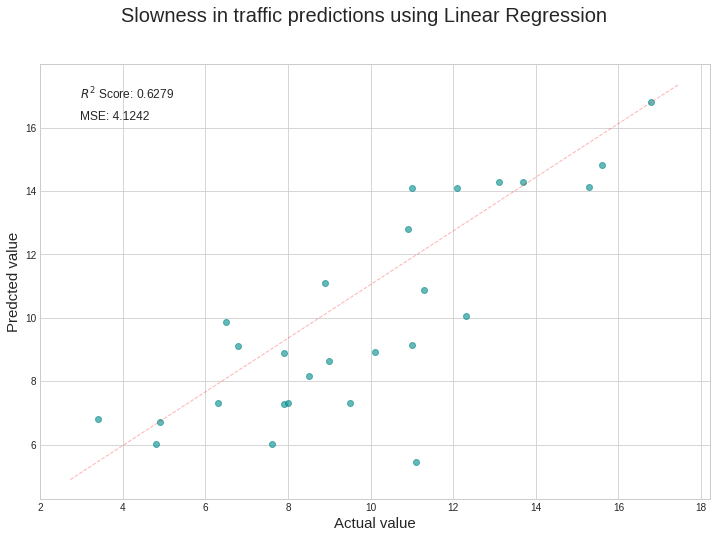

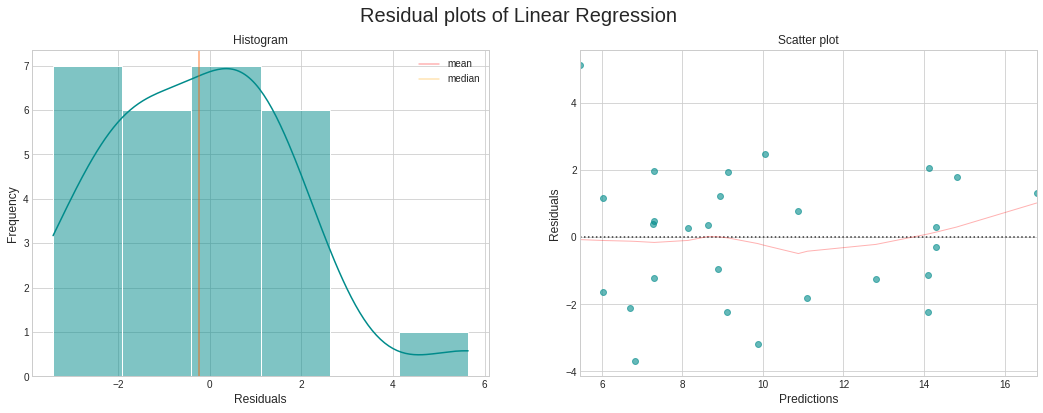

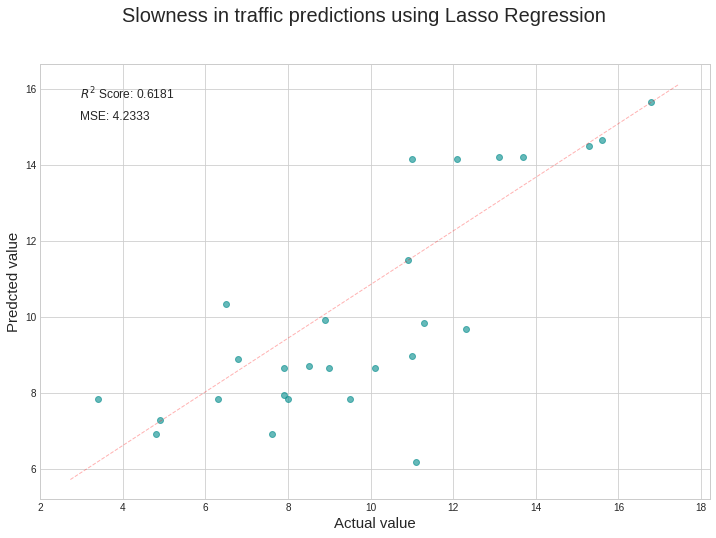

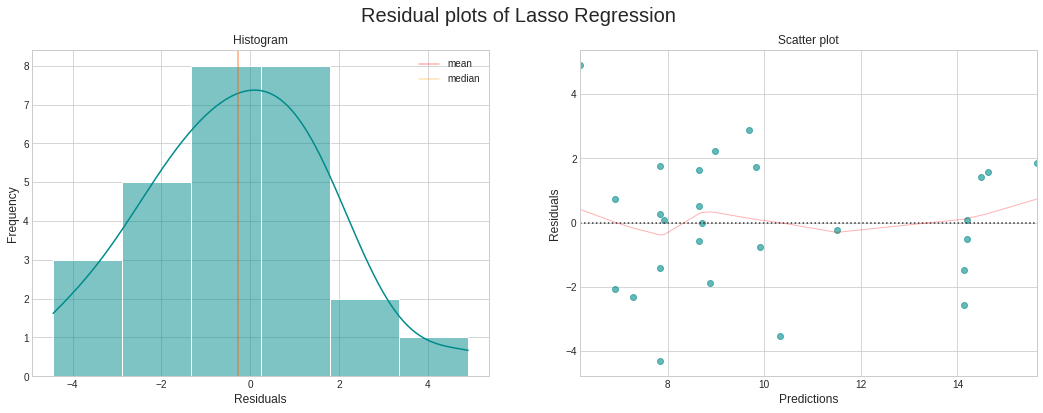

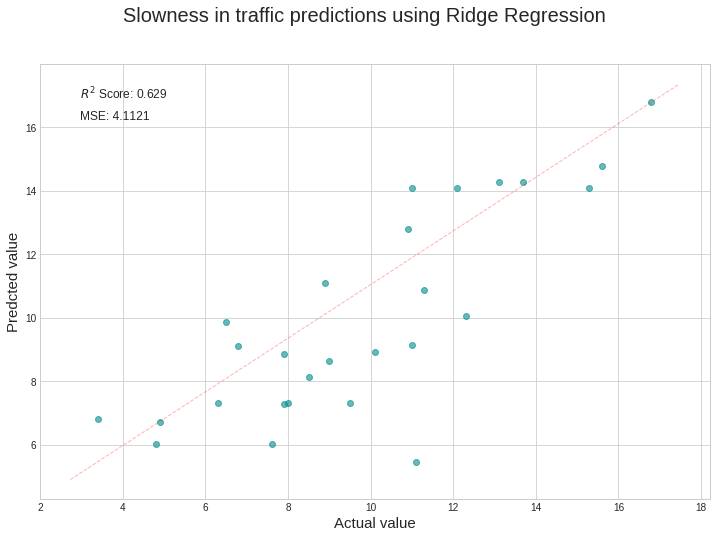

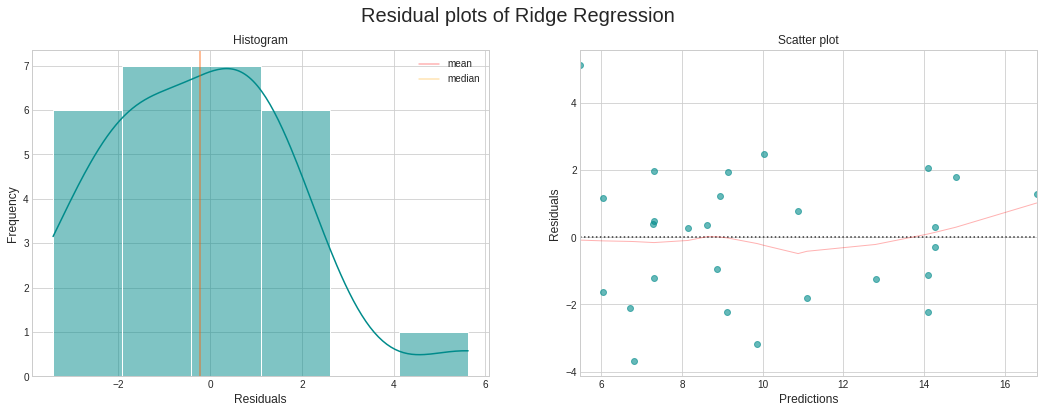

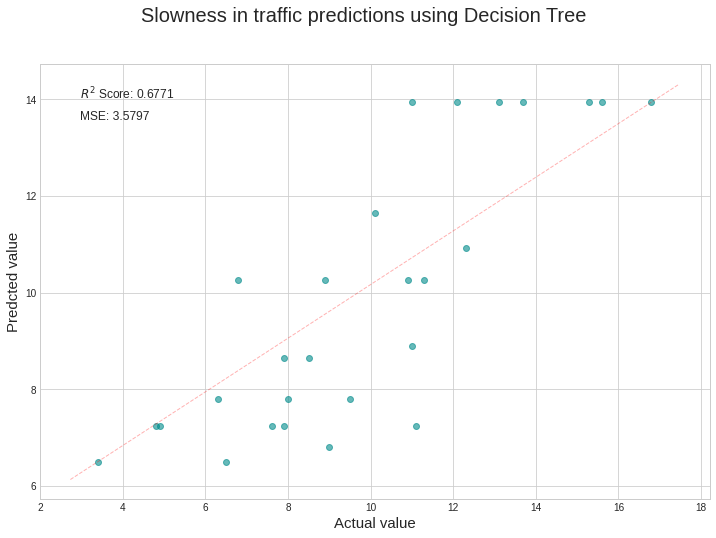

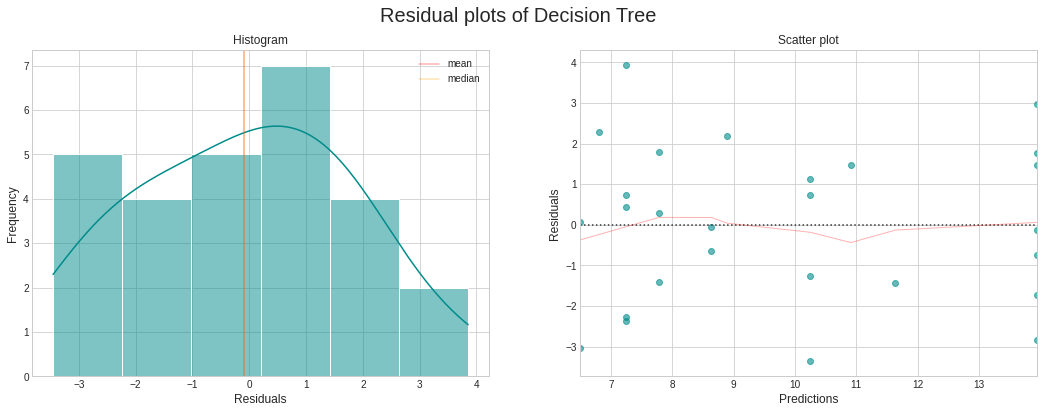

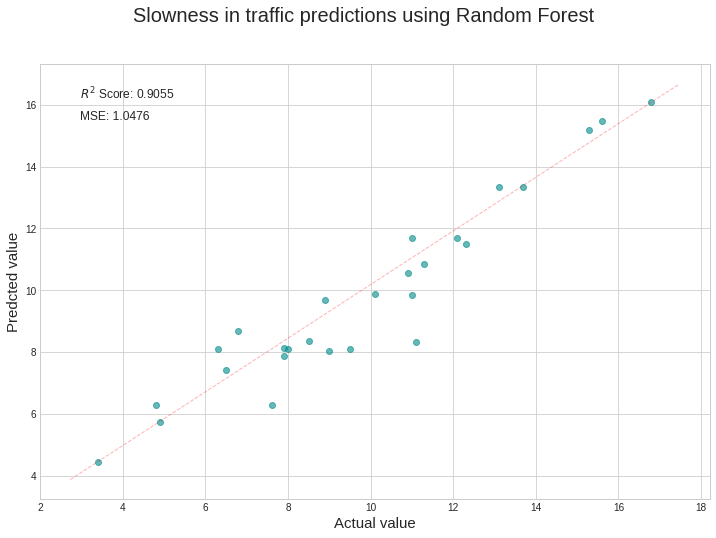

[18:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


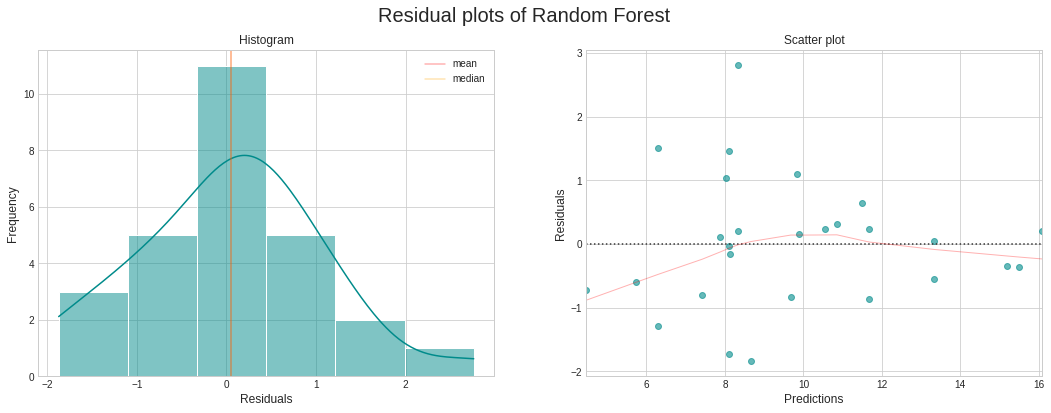

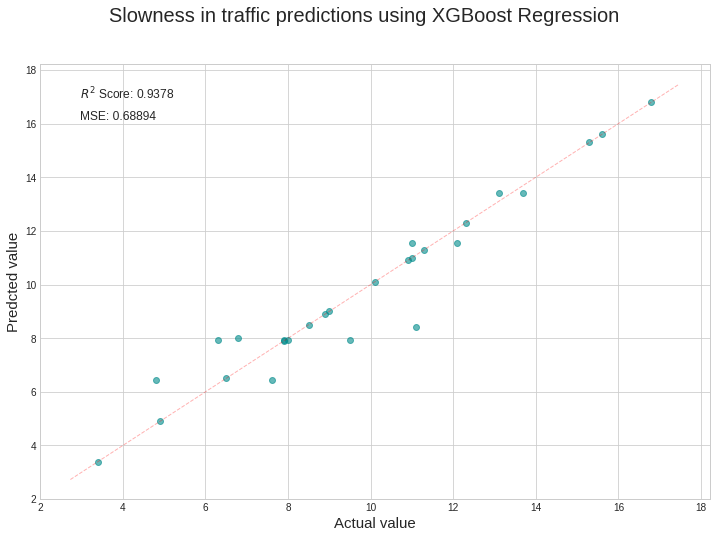

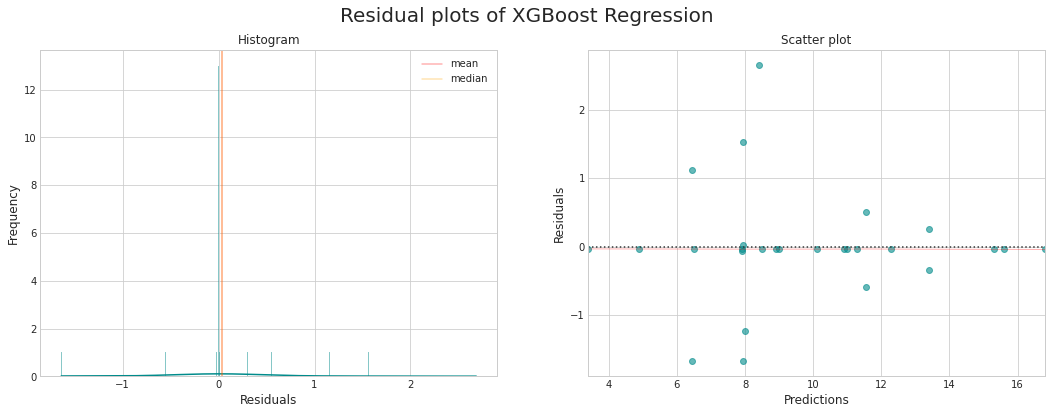

In [88]:
for model_name in trained_models.keys():
    #Getting the trained model.
    model = trained_models[model_name]['estimator']
    
    #Fitting on the dataset.
    model.fit(X,y)

    #Making predictions on the test dataset.
    y_pred = model.predict(X_test)

    #Estimating the scores.
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    test_preds[model_name] = {'R2 Score': r2, 'Mean Squared Error': mse}

    plt_target(y_test, y_pred, r2, mse, model_name)
    plt_residuals(y_test, y_pred, model_name, figsize=(18, 6))



In [94]:
style_df(pd.DataFrame(test_preds).T)

,R2 Score,Mean Squared Error
Linear Regression,0.627937,4.124209
Lasso Regression,0.618098,4.233261
Ridge Regression,0.629026,4.112136
Decision Tree,0.677058,3.579712
Random Forest,0.905491,1.047598
XGBoost Regression,0.937848,0.688939
